In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from ignite.metrics import Accuracy
from tqdm import tqdm
import sys
sys.path.append('/home/lindi/chenhr/threed/pointnext/partseg')
from dataset import ShapeNet
from data_aug import *
import fps_cuda
import seaborn as sns
import matplotlib.pyplot as plt
from memorynet_partseg_2 import Memorynet

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
val_aug = Compose([PointCloudCenterAndNormalize()])
val_dataset = ShapeNet('/home/lindi/chenhr/threed/data/shapenetcore_partanno_segmentation_benchmark_v0_normal', 
                        split='test', npoints=2048, transforms=val_aug)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=8)

device = 'cuda:4'

model = Memorynet(50).to(device)
model_path = '/home/lindi/chenhr/threed/pointnext/partseg/checkpoints/memorynet_partseg.pth'
model.load_state_dict(torch.load(model_path, map_location=device)['model_state_dict'])
model.eval()

val_dataloader = iter(val_dataloader)
for i in range(15):
    pos, x, y, object_label = next(val_dataloader)
pos = pos.to(device)
x = x.to(device)
y = y.to(device)
object_label = object_label.to(device)

with torch.no_grad():
    _, _, attn_map, coarse_pred1, y3 = model(pos, x, object_label, y)

coarse_pred1 = coarse_pred1.transpose(1, 2).softmax(dim=-1)
print(attn_map.shape, coarse_pred1.shape, y3.shape)
attn_map = attn_map.to(device='cpu').numpy()
coarse_pred1 = coarse_pred1.to(device='cpu').numpy()
y3 = y3.to(device='cpu').numpy()

torch.Size([32, 256, 50]) torch.Size([32, 256, 50]) torch.Size([32, 256])


<AxesSubplot: >

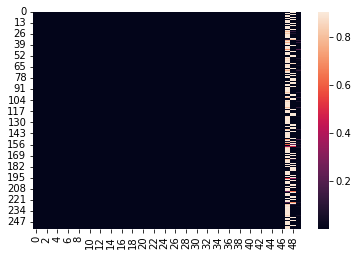

In [3]:
sns.heatmap(coarse_pred1[0])

<AxesSubplot: >

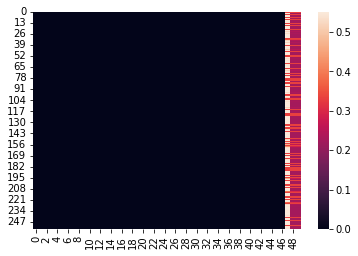

In [4]:
sns.heatmap(attn_map[0])